In [1]:
### Cell written by Caro Gass ###

import numpy as np 
import random
import copy
import matplotlib.pyplot as plt

# online plotting
%matplotlib notebook  

def chunks(l, n):
    # helper function for reading in our data
    # creates chunks of a specific size
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]
        

# Read in the different problems
# Problem 1:
with open('1.tsp','r') as text:
    tsp_read = text.read()
    numbers = [int(i) for i in tsp_read.split()]
# splits the list into a 150 x 150 list
dist1 = list(chunks(numbers, int(np.sqrt(len(numbers)))))

# Problem 2:
with open('2.tsp','r') as text:
    tsp_read = text.read()
    numbers = [int(i) for i in tsp_read.split()]
# splits the list into a 150 x 150 list
dist2 = list(chunks(numbers, int(np.sqrt(len(numbers)))))

# Problem 3:
with open('3.tsp','r') as text:
    tsp_read = text.read()
    numbers = [int(i) for i in tsp_read.split()]
# splits the list into a 150 x 150 list
dist3 = list(chunks(numbers, int(np.sqrt(len(numbers)))))

In [2]:
### Cell written by Kimberly Gerbaulet ###

def initialization(ph_value, dist):
    # ph_value= initial pheromone value
    # dist = distance matrix
    # pheromone_mat = pheromone matrix
    # heuristic_matrix = inverse of the distance matrix

    pheromone_mat = np.full((len(dist), len(dist)), ph_value) # create matrix, fill it with a specific number
    np.fill_diagonal(pheromone_mat, 0) #make the diagonal zero
    
    #inverse of the distance matrix
    heuristic_matrix = 1/np.array(dist) #function that gives the inverse of a matrix
    
    return pheromone_mat, heuristic_matrix

In [3]:
### Function written by Caro Gass, Ann-Christin Meisener ###

# Helper functions for the solution construction
def ant_probability(current_city, z, pheromone_mat, h_mat, alpha, beta):
    # the current_city refers to our ant's location
    # z is the list of cities left to pool from for our ant
    # this function is an implementation of the probability function
    # p_ij = (t_ij^alpha * n_ij^beta)/sum(t_iz^alpha*n_iz^beta)
    
    probabilities = []
    pheromones = np.array([])
    heuristics = np.array([])

    # we first create all t_iz^alpha (pheromones) and all n_iz^beta (heuristics)
    for city in z:
        pheromones = np.append(pheromones, pheromone_mat[current_city][city]**alpha)
        heuristics = np.append(heuristics, h_mat[current_city][city]**beta)
    
    # then we compute the denominator
    denominator = np.matmul(pheromones, heuristics)
    
    # afterwards we compute the probability of each city left in our set z = Z[a]
    
    for city in z:
        city_index = z.index(city)
        probabilities.append(pheromones[city_index]*heuristics[city_index]/denominator)
    
    return probabilities  # the list of probabilities for choosing each city in z

In [4]:
### Function written by Shahd Safarani ###

#Roulette Wheel selection   
#return the index of randomly chosen city
def roulette_wheel(probabilities):
        
    #For accumulating the probability for later use
    previous_probability = 0.0
    cumulative_probability = probabilities.copy()
    for i, p in enumerate(probabilities):
        cumulative_probability[i] = previous_probability + cumulative_probability[i]
        previous_probability = cumulative_probability[i]
    #Choosing probabilitistically randomly 
    rand = random.uniform(0, 1)
    
    for index in range(len(cumulative_probability)):
        if rand < cumulative_probability[index]: 
            break
        
    return index

In [5]:
### Cell written by Caro Gass and Ann-Christin Meisener ###

# Solution Construction of ACO
def solution_construction(A, dist, pheromone_mat, h_mat, alpha, beta, mode='roulette_wheel'):
    # A is the number of ants
    # dist is the distance matrix
    # pheromone_mat is the current pheromone matrix
    # h_mat is the heuristic matrix (h_ij = 1/dist_ij)
    # alpha for weighting the pheromone value
    # beta for weighting the heuristic value, e.g. the city distance
    # mode determines the mode used to choose the city given the probabilities
    
    S = list(range(len(dist)))  # list of cities
    M = [list([]) for i in range(A)]  # the tours of all A ants
   
    for a in range(A):
        z = copy.copy(S)  # a copy of our city list for an ant to pool from
        # each ant gets it's starting city assigned
        start = random.choice(z)
        M[a].append(start)
        z.remove(start)  # remove the starting point from an ant's city-pooling list
        
        # create tours
        while z:
            current_city = M[a][-1]  # look up the current city
            city_probabilities = ant_probability(current_city,z,pheromone_mat, h_mat, alpha, beta)
            if mode == 'max':
                # chose next city by maximum probability value
                next_city_index = city_probabilities.index(max(city_probabilities))
            if mode == 'roulette_wheel':
                # chose next city using the roulette wheel
                next_city_index = roulette_wheel(city_probabilities)
            
            next_city = z[next_city_index]
            M[a].append(next_city)
            z.remove(next_city)
            
    return M  #return a list of the tours of all ants


In [6]:
### Cell written by Jannik Zeiser ###

# pheromone on each path evaporates by a defined factor. Returns updated pheromone matrix.

def evaporator(pher_matrix, ev_parameter=0.2):
    pher_matrix_new = (1-ev_parameter) * np.array(pher_matrix)
    return pher_matrix_new


In [7]:
### Cell written by Shahd Safarani ###

def walked_through(a_tour, s, e):
    for i in range(-1, len(a_tour)-1):
        if a_tour[i]==s and a_tour[i+1]==e:
            return True
    return False

# pheromone matrix intensification here
def intensification(pheromones, M, dist_mat, p, delta=0.2, mode='best_ant'):
    if mode == 'best_ant':
        best, index = ants_fitness_best(M, dist_mat)
        return [[pheromones[i][j]+delta if walked_through(M[index], i, j)
                 else pheromones[i][j]
                 for j in range(len(pheromones))] for i in range(len(pheromones))]
    
    if mode == 'all-ants':
        fitnesses = ants_fitness(M, dist_mat)
        result = p * np.sum( np.array([ [ [ 1/fitnesses[idx] if walked_through(M[idx], i, j) 
                                                       else 0 for idx, ant in enumerate(M)] 
                                                      for j in range(len(pheromones))] 
                                                    for i in range(len(pheromones))]) , 2)
        return result


In [8]:
### Cell written by Adrián Rojas ###

#Returns a list with the fitness of every ant.
def ants_fitness(M, dist_mat):
    fitness = []

    x = 0
    # Goes to every list in M
    while (x < len(M)):
        # starts in -1 so it counts the back to the origin
        y = -1
        temp = 0
        j = M[x]

        # Goes to every list in M[x] 
        while (y < len(j)-1):
            a = j[y]
            b = j[y+1]
            # Add up all paths from the ant's tour
            temp = temp + dist_mat[a][b]
            y += 1 
        fitness.append(temp)
        x += 1

    return fitness


# Returns an integer with the fitness of the best ant.
def ants_fitness_best(M, dist_mat):
    fitness_best = ants_fitness(M, dist_mat)
    index = fitness_best.index(max(fitness_best))
    fitness_best.sort()
    return fitness_best[0], index


## implement solution generation with:
### 1  distance heuristic (parameters α, β)
### 2 distance heuristic with fixed parameters α = 1, β = 0
### 3 distance heuristic with fixed parameters α = 1, β = 1

## We will decode the exercises in problem.variation (1.1 , 1.2 , 1.3 , 2.1 , 2.2 , 2.3 , 3.1 , 3.2 , 3.3).

# Each Problem has it's own initialization cell, which has to be executed 
# before trying any of its subproblems!!!

<IPython.core.display.Javascript object>


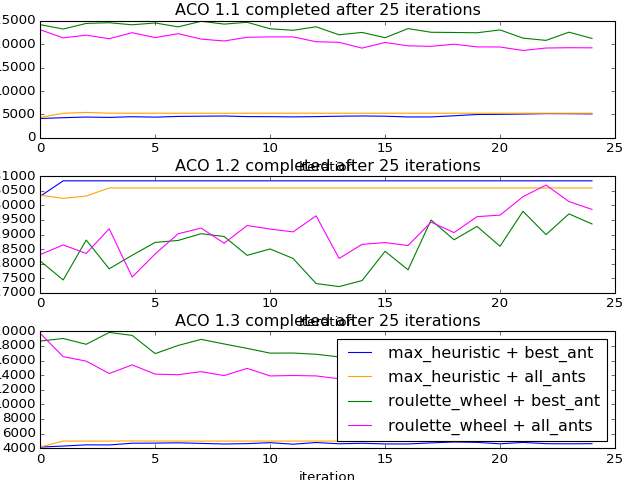

In [11]:
### Cell is a group work by all members ###

# Exploration Problem 1 - this cell has to be executed before exploring any subproblem of P1 !!!!!!

# Best HC solution found: 6,376 (FCHC, Transposition)
# Best ACO solution found: 3,632
# Strict (probably not tight) Lower Bound: 2,502

A = 5  # number of ants
iterations = 25 # number of iterations
ph_value = 0.5  # pheromone matrix initialisation parameter
ev_parameter = 0.2  # evaporation parameter  ("proportion")
delta = 0.1    # intensification parameter
combinations = 4  # number of mode combinations we try
dist = dist1  # assign problem 1

# Online plotting
plt.ion()
figs, (ax1, ax2, ax3) = plt.subplots(3,1)
figs.tight_layout()

In [12]:
# 1.1
def ACO_P1_1(A, iterations, dist, ph_value, ev_parameter, delta, combinations, fig, ax):    
    alpha = 1
    beta = 0.5
    
    pheromone_mat, h_mat = initialization(ph_value, dist)
    #create a pheromone matrix and a heutistic matrix for each mode variation
    pheromone_mat = [list(pheromone_mat) for c in range(combinations)]
    h_mat = [list(h_mat) for c in range(combinations)]
    best_fitness_each = []
    # create a best fitness list for each mode combination:
    best_fitness_mat = [list([]) for i in range(combinations)] 


    for i in range(iterations): # number of iterations defined here
        print('iteration No:', i)
        c = 0
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
                
        # online plotting
        ax.cla()
        ax.plot(best_fitness_mat[c], c='blue', label='max_heuristic + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()
    
    for i in range(iterations): # number of iterations defined here
        c = 1
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='orange', label='max_heuristic + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 2
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='green', label='roulette_wheel + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 3
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='magenta', label='roulette_wheel + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        plt.legend(loc=1) 
        fig.canvas.draw()
        
    # create the final subplot
    colors=['blue', 'orange', 'green', 'magenta']
    labels=['max_heuristic + best_ant', 'max_heuristic + all_ants', 'roulette_wheel + best_ant', 'roulette_wheel + all_ants']
    ax.cla()
    for comb in range(combinations):
        best_fitness_each.append(max(best_fitness_mat[comb]))
        ax.plot(best_fitness_mat[comb], c=colors[comb], label=labels[comb])
        
    ax.set_title('ACO 1.1 completed after %i iterations' % iterations)
    ax.set_ylabel("distances")
    ax.set_xlabel("iteration")
    plt.legend(loc=1)
    fig.canvas.draw()   
    
    return best_fitness_each, pheromone_mat

best_fitness_each, _ = ACO_P1_1(A, iterations, dist, ph_value, ev_parameter, delta, combinations, figs, ax1)
print('Problem 1.1 - Best fitness of each modification:', best_fitness_each)

c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


iteration No: 0
iteration No: 1
iteration No: 2
iteration No: 3
iteration No: 4
iteration No: 5
iteration No: 6
iteration No: 7
iteration No: 8
iteration No: 9
iteration No: 10
iteration No: 11
iteration No: 12
iteration No: 13
iteration No: 14
iteration No: 15
iteration No: 16
iteration No: 17
iteration No: 18
iteration No: 19
iteration No: 20
iteration No: 21
iteration No: 22
iteration No: 23
iteration No: 24


c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Problem 1.1 - Best fitness of each modification: [5166, 5418, 24920, 23104]


In [13]:
# 1.2
def ACO_P1_2(A, iterations, dist, ph_value, ev_parameter, delta, combinations, fig, ax):
    alpha = 1
    beta = 0

    pheromone_mat, h_mat = initialization(ph_value, dist)
    #create a pheromone matrix and a heutistic matrix for each mode variation
    pheromone_mat = [list(pheromone_mat) for c in range(combinations)]
    h_mat = [list(h_mat) for c in range(combinations)]
    best_fitness_each = []
    # create a best fitness list for each mode combination:
    best_fitness_mat = [list([]) for i in range(combinations)] 


    for i in range(iterations): # number of iterations defined here
        print('iteration No:', i)
        c = 0
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
                
        # online plotting
        ax.cla()
        ax.plot(best_fitness_mat[c], c='blue', label='max_heuristic + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()
    
    for i in range(iterations): # number of iterations defined here
        c = 1
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='orange', label='max_heuristic + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 2
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='green', label='roulette_wheel + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 3
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='magenta', label='roulette_wheel + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        plt.legend(loc=1) 
        fig.canvas.draw()
        
    # create the final subplot
    colors=['blue', 'orange', 'green', 'magenta']
    labels=['max_heuristic + best_ant', 'max_heuristic + all_ants', 'roulette_wheel + best_ant', 'roulette_wheel + all_ants']
    ax.cla()
    for comb in range(combinations):
        best_fitness_each.append(max(best_fitness_mat[comb]))
        ax.plot(best_fitness_mat[comb], c=colors[comb], label=labels[comb])
             
    ax.set_title('ACO 1.2 completed after %i iterations' % iterations)
    ax.set_ylabel("distances")
    ax.set_xlabel("iteration")
    plt.legend(loc=1)
    fig.canvas.draw()     
    
    return best_fitness_each, pheromone_mat

best_fitness_each, _ = ACO_P1_2(A, iterations, dist, ph_value, ev_parameter, delta, combinations, figs, ax2)
print('Problem 1.2 - Best fitness of each modification:', best_fitness_each)

c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


iteration No: 0
iteration No: 1
iteration No: 2
iteration No: 3
iteration No: 4
iteration No: 5
iteration No: 6
iteration No: 7
iteration No: 8
iteration No: 9
iteration No: 10
iteration No: 11
iteration No: 12
iteration No: 13
iteration No: 14
iteration No: 15
iteration No: 16
iteration No: 17
iteration No: 18
iteration No: 19
iteration No: 20
iteration No: 21
iteration No: 22
iteration No: 23
iteration No: 24


c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Problem 1.2 - Best fitness of each modification: [30838, 30594, 29796, 30694]


In [14]:
# 1.3
def ACO_P1_3(A, iterations, dist, ph_value, ev_parameter, delta, combinations, fig, ax):
    alpha = 1
    beta = 1

    pheromone_mat, h_mat = initialization(ph_value, dist)
    #create a pheromone matrix and a heutistic matrix for each mode variation
    pheromone_mat = [list(pheromone_mat) for c in range(combinations)]
    h_mat = [list(h_mat) for c in range(combinations)]
    best_fitness_each = []
    # create a best fitness list for each mode combination:
    best_fitness_mat = [list([]) for i in range(combinations)] 


    for i in range(iterations): # number of iterations defined here
        print('iteration No:', i)
        c = 0
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
                
        # online plotting
        ax.cla()
        ax.plot(best_fitness_mat[c], c='blue', label='max_heuristic + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()
    
    for i in range(iterations): # number of iterations defined here
        c = 1
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='orange', label='max_heuristic + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 2
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='green', label='roulette_wheel + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 3
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='magenta', label='roulette_wheel + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        plt.legend(loc=1) 
        fig.canvas.draw() 
        
    # create the final subplot
    colors=['blue', 'orange', 'green', 'magenta']
    labels=['max_heuristic + best_ant', 'max_heuristic + all_ants', 'roulette_wheel + best_ant', 'roulette_wheel + all_ants']
    ax.cla()
    for comb in range(combinations):
        best_fitness_each.append(max(best_fitness_mat[comb]))
        ax.plot(best_fitness_mat[comb], c=colors[comb], label=labels[comb])
             
    ax.set_title('ACO 1.3 completed after %i iterations' % iterations)
    ax.set_ylabel("distances")
    ax.set_xlabel("iteration")
    plt.legend(loc=1)
    fig.canvas.draw()     
    
    return best_fitness_each, pheromone_mat

best_fitness_each, _ = ACO_P1_3(A, iterations, dist, ph_value, ev_parameter, delta, combinations, figs, ax3)
print('Problem 1.3 - Best fitness of each modification:', best_fitness_each)

c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


iteration No: 0
iteration No: 1
iteration No: 2
iteration No: 3
iteration No: 4
iteration No: 5
iteration No: 6
iteration No: 7
iteration No: 8
iteration No: 9
iteration No: 10
iteration No: 11
iteration No: 12
iteration No: 13
iteration No: 14
iteration No: 15
iteration No: 16
iteration No: 17
iteration No: 18
iteration No: 19
iteration No: 20
iteration No: 21
iteration No: 22
iteration No: 23
iteration No: 24


c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


Problem 1.3 - Best fitness of each modification: [4846, 4984, 19842, 19716]


<IPython.core.display.Javascript object>


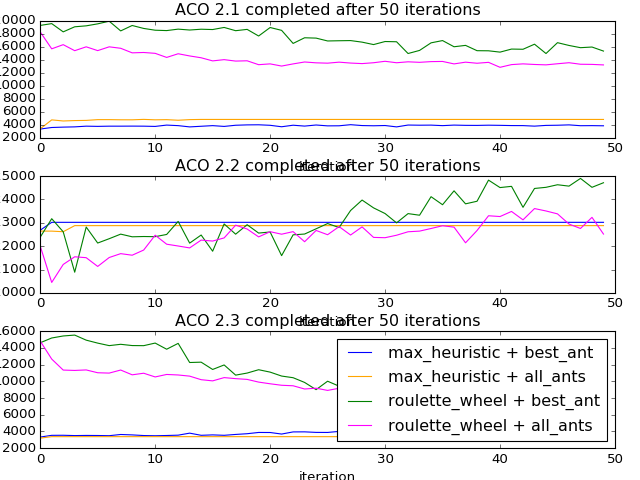

In [15]:
### Cell is a group work by all members ###

# Exploration Problem 2  - this cell has to be executed before exploring any subproblem of P2 !!!!!!

# Best HC solution found: 4,315 (FCHC, Transposition)
# Best ACO solution found: 2,878
# Strict (probably not tight) Lower Bound: 1,971

A = 5  # number of ants
iterations = 50 # number of iterations
ph_value = 0.5  # pheromone matrix initialisation parameter
ev_parameter = 0.2  # evaporation parameter  ("proportion")
delta = 0.1    # intensification parameter
combinations = 4  # number of mode combinations we try
dist = dist2  # assign problem 2

# Online plotting
plt.ion()
figs, (ax1, ax2, ax3) = plt.subplots(3,1)
figs.tight_layout()

In [16]:
# 2.1
def ACO_P2_1(A, iterations, dist, ph_value, ev_parameter, delta, combinations, fig, ax):    
    alpha = 1
    beta = 0.5
    
    pheromone_mat, h_mat = initialization(ph_value, dist)
    #create a pheromone matrix and a heutistic matrix for each mode variation
    pheromone_mat = [list(pheromone_mat) for c in range(combinations)]
    h_mat = [list(h_mat) for c in range(combinations)]
    best_fitness_each = []
    # create a best fitness list for each mode combination:
    best_fitness_mat = [list([]) for i in range(combinations)] 


    for i in range(iterations): # number of iterations defined here
        print('iteration No:', i)
        c = 0
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
                
        # online plotting
        ax.cla()
        ax.plot(best_fitness_mat[c], c='blue', label='max_heuristic + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()
    
    for i in range(iterations): # number of iterations defined here
        c = 1
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='orange', label='max_heuristic + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 2
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='green', label='roulette_wheel + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 3
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[3], c='magenta', label='roulette_wheel + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        plt.legend(loc=1) 
        fig.canvas.draw()
        
    # create the final subplot
    colors=['blue', 'orange', 'green', 'magenta']
    labels=['max_heuristic + best_ant', 'max_heuristic + all_ants', 'roulette_wheel + best_ant', 'roulette_wheel + all_ants']
    ax.cla()
    for comb in range(combinations):
        best_fitness_each.append(max(best_fitness_mat[comb]))
        ax.plot(best_fitness_mat[comb], c=colors[comb], label=labels[comb])
        
    ax.set_title('ACO 2.1 completed after %i iterations' % iterations)
    ax.set_ylabel("distances")
    ax.set_xlabel("iteration")
    plt.legend(loc=1)
    fig.canvas.draw()     
    
    return best_fitness_each, pheromone_mat

best_fitness_each, _ = ACO_P2_1(A, iterations, dist, ph_value, ev_parameter, delta, combinations, figs, ax1)
print('Problem 2.1 - Best fitness of each modification:', best_fitness_each)

c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


iteration No: 0
iteration No: 1
iteration No: 2
iteration No: 3
iteration No: 4
iteration No: 5
iteration No: 6
iteration No: 7
iteration No: 8
iteration No: 9
iteration No: 10
iteration No: 11
iteration No: 12
iteration No: 13
iteration No: 14
iteration No: 15
iteration No: 16
iteration No: 17
iteration No: 18
iteration No: 19
iteration No: 20
iteration No: 21
iteration No: 22
iteration No: 23
iteration No: 24
iteration No: 25
iteration No: 26
iteration No: 27
iteration No: 28
iteration No: 29
iteration No: 30
iteration No: 31
iteration No: 32
iteration No: 33
iteration No: 34
iteration No: 35
iteration No: 36
iteration No: 37
iteration No: 38
iteration No: 39
iteration No: 40
iteration No: 41
iteration No: 42
iteration No: 43
iteration No: 44
iteration No: 45
iteration No: 46
iteration No: 47
iteration No: 48
iteration No: 49


c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Problem 2.1 - Best fitness of each modification: [4013, 4829, 19955, 18303]


In [17]:
# 2.2
def ACO_P2_2(A, iterations, dist, ph_value, ev_parameter, delta, combinations, fig, ax):
    alpha = 1
    beta = 0

    pheromone_mat, h_mat = initialization(ph_value, dist)
    #create a pheromone matrix and a heutistic matrix for each mode variation
    pheromone_mat = [list(pheromone_mat) for c in range(combinations)]
    h_mat = [list(h_mat) for c in range(combinations)]
    best_fitness_each = []
    # create a best fitness list for each mode combination:
    best_fitness_mat = [list([]) for i in range(combinations)] 


    for i in range(iterations): # number of iterations defined here
        print('iteration No:', i)
        c = 0
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
                
        # online plotting
        ax.cla()
        ax.plot(best_fitness_mat[c], c='blue', label='max_heuristic + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()
    
    for i in range(iterations): # number of iterations defined here
        c = 1
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='orange', label='max_heuristic + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 2
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='green', label='roulette_wheel + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 3
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='magenta', label='roulette_wheel + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        plt.legend(loc=1) 
        fig.canvas.draw()     
        
    # create the final subplot
    colors=['blue', 'orange', 'green', 'magenta']
    labels=['max_heuristic + best_ant', 'max_heuristic + all_ants', 'roulette_wheel + best_ant', 'roulette_wheel + all_ants']
    ax.cla()
    for comb in range(combinations):
        best_fitness_each.append(max(best_fitness_mat[comb]))
        ax.plot(best_fitness_mat[comb], c=colors[comb], label=labels[comb])
             
    ax.set_title('ACO 2.2 completed after %i iterations' % iterations)
    ax.set_ylabel("distances")
    ax.set_xlabel("iteration")
    plt.legend(loc=1)
    fig.canvas.draw()     
    
    return best_fitness_each, pheromone_mat

best_fitness_each, _ = ACO_P2_2(A, iterations, dist, ph_value, ev_parameter, delta, combinations, figs, ax2)
print('Problem 2.2 - Best fitness of each modification:', best_fitness_each)

c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


iteration No: 0
iteration No: 1
iteration No: 2
iteration No: 3
iteration No: 4
iteration No: 5
iteration No: 6
iteration No: 7
iteration No: 8
iteration No: 9
iteration No: 10
iteration No: 11
iteration No: 12
iteration No: 13
iteration No: 14
iteration No: 15
iteration No: 16
iteration No: 17
iteration No: 18
iteration No: 19
iteration No: 20
iteration No: 21
iteration No: 22
iteration No: 23
iteration No: 24
iteration No: 25
iteration No: 26
iteration No: 27
iteration No: 28
iteration No: 29
iteration No: 30
iteration No: 31
iteration No: 32
iteration No: 33
iteration No: 34
iteration No: 35
iteration No: 36
iteration No: 37
iteration No: 38
iteration No: 39
iteration No: 40
iteration No: 41
iteration No: 42
iteration No: 43
iteration No: 44
iteration No: 45
iteration No: 46
iteration No: 47
iteration No: 48
iteration No: 49


c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Problem 2.2 - Best fitness of each modification: [23022, 22881, 24901, 23611]


In [18]:
# 2.3
def ACO_P2_3(A, iterations, dist, ph_value, ev_parameter, delta, combinations, fig, ax):
    alpha = 1
    beta = 1

    pheromone_mat, h_mat = initialization(ph_value, dist)
    #create a pheromone matrix and a heutistic matrix for each mode variation
    pheromone_mat = [list(pheromone_mat) for c in range(combinations)]
    h_mat = [list(h_mat) for c in range(combinations)]
    best_fitness_each = []
    # create a best fitness list for each mode combination:
    best_fitness_mat = [list([]) for i in range(combinations)] 


    for i in range(iterations): # number of iterations defined here
        print('iteration No:', i)
        c = 0
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
                
        # online plotting
        ax.cla()
        ax.plot(best_fitness_mat[c], c='blue', label='max_heuristic + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()
    
    for i in range(iterations): # number of iterations defined here
        c = 1
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='orange', label='max_heuristic + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 2
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='green', label='roulette_wheel + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 3
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='magenta', label='roulette_wheel + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        plt.legend(loc=1) 
        fig.canvas.draw()
        
    # create the final subplot
    colors=['blue', 'orange', 'green', 'magenta']
    labels=['max_heuristic + best_ant', 'max_heuristic + all_ants', 'roulette_wheel + best_ant', 'roulette_wheel + all_ants']
    ax.cla()
    for comb in range(combinations):
        best_fitness_each.append(max(best_fitness_mat[comb]))
        ax.plot(best_fitness_mat[comb], c=colors[comb], label=labels[comb])
        
    ax.set_title('ACO 2.3 completed after %i iterations' % iterations)
    ax.set_ylabel("distances")
    ax.set_xlabel("iteration")
    plt.legend(loc=1)
    fig.canvas.draw()     
    
    return best_fitness_each, pheromone_mat

best_fitness_each, _ = ACO_P2_3(A, iterations, dist, ph_value, ev_parameter, delta, combinations, figs, ax3)
print('Problem 2.3 - Best fitness of each modification:', best_fitness_each)

c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


iteration No: 0
iteration No: 1
iteration No: 2
iteration No: 3
iteration No: 4
iteration No: 5
iteration No: 6
iteration No: 7
iteration No: 8
iteration No: 9
iteration No: 10
iteration No: 11
iteration No: 12
iteration No: 13
iteration No: 14
iteration No: 15
iteration No: 16
iteration No: 17
iteration No: 18
iteration No: 19
iteration No: 20
iteration No: 21
iteration No: 22
iteration No: 23
iteration No: 24
iteration No: 25
iteration No: 26
iteration No: 27
iteration No: 28
iteration No: 29
iteration No: 30
iteration No: 31
iteration No: 32
iteration No: 33
iteration No: 34
iteration No: 35
iteration No: 36
iteration No: 37
iteration No: 38
iteration No: 39
iteration No: 40
iteration No: 41
iteration No: 42
iteration No: 43
iteration No: 44
iteration No: 45
iteration No: 46
iteration No: 47
iteration No: 48
iteration No: 49


c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


Problem 2.3 - Best fitness of each modification: [4182, 3378, 15547, 14832]


<IPython.core.display.Javascript object>


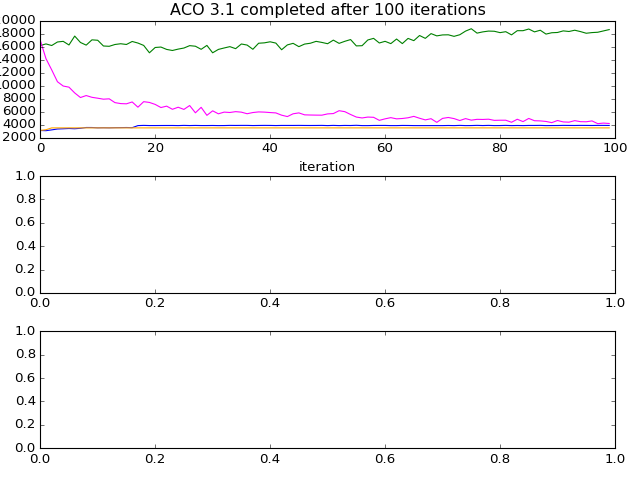

In [21]:
### Cell is a group work by all members ###

# Exploration Problem 3  - this cell has to be executed before exploring any subproblem of P3 !!!!!!

# Best HC solution found: 4,508 (FCHC, Transposition)
# Best ACO solution found: 2,617
# Strict (probably not tight) Lower Bound: 1,728

A = 25  # number of ants
iterations = 100 # number of iterations
ph_value = 0.5  # pheromone matrix initialisation parameter
ev_parameter = 0.2  # evaporation parameter  ("proportion")
delta = 0.1    # intensification parameter
combinations = 4  # number of mode combinations we try
dist = dist3  # assign problem 2

# Online plotting
plt.ion()
figs, (ax1, ax2, ax3) = plt.subplots(3,1)
figs.tight_layout()

In [22]:
# 3.1
def ACO_P3_1(A, iterations, dist, ph_value, ev_parameter, delta, combinations, fig, ax):    
    alpha = 1
    beta = 0.5
    
    pheromone_mat, h_mat = initialization(ph_value, dist)
    #create a pheromone matrix and a heutistic matrix for each mode variation
    pheromone_mat = [list(pheromone_mat) for c in range(combinations)]
    h_mat = [list(h_mat) for c in range(combinations)]
    best_fitness_each = []
    # create a best fitness list for each mode combination:
    best_fitness_mat = [list([]) for i in range(combinations)] 


    for i in range(iterations): # number of iterations defined here
        print('iteration No:', i)
        c = 0
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
                
        # online plotting
        ax.cla()
        ax.plot(best_fitness_mat[c], c='blue', label='max_heuristic + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()
    
    for i in range(iterations): # number of iterations defined here
        c = 1
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='orange', label='max_heuristic + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 2
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='green', label='roulette_wheel + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 3
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='magenta', label='roulette_wheel + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        plt.legend(loc=1) 
        fig.canvas.draw() 
    
    # create the final subplot
    colors=['blue', 'orange', 'green', 'magenta']
    labels=['max_heuristic + best_ant', 'max_heuristic + all_ants', 'roulette_wheel + best_ant', 'roulette_wheel + all_ants']
    ax.cla()
    for comb in range(combinations):
        best_fitness_each.append(max(best_fitness_mat[comb]))
        ax.plot(best_fitness_mat[comb], c=colors[comb], label=labels[comb])
             
    ax.set_title('ACO 3.1 completed after %i iterations' % iterations)
    ax.set_ylabel("distances")
    ax.set_xlabel("iteration")
    plt.legend(loc=1)
    fig.canvas.draw()     
    
    return best_fitness_each, pheromone_mat

best_fitness_each, _ = ACO_P3_1(A, iterations, dist, ph_value, ev_parameter, delta, combinations, figs, ax1)
print('Problem 3.1 - Best fitness of each modification:', best_fitness_each)

c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


iteration No: 0
iteration No: 1
iteration No: 2
iteration No: 3
iteration No: 4
iteration No: 5
iteration No: 6
iteration No: 7
iteration No: 8
iteration No: 9
iteration No: 10
iteration No: 11
iteration No: 12
iteration No: 13
iteration No: 14
iteration No: 15
iteration No: 16
iteration No: 17
iteration No: 18
iteration No: 19
iteration No: 20
iteration No: 21
iteration No: 22
iteration No: 23
iteration No: 24
iteration No: 25
iteration No: 26
iteration No: 27
iteration No: 28
iteration No: 29
iteration No: 30
iteration No: 31
iteration No: 32
iteration No: 33
iteration No: 34
iteration No: 35
iteration No: 36
iteration No: 37
iteration No: 38
iteration No: 39
iteration No: 40
iteration No: 41
iteration No: 42
iteration No: 43
iteration No: 44
iteration No: 45
iteration No: 46
iteration No: 47
iteration No: 48
iteration No: 49
iteration No: 50
iteration No: 51
iteration No: 52
iteration No: 53
iteration No: 54
iteration No: 55
iteration No: 56
iteration No: 57
iteration No: 58
iterati

c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
c:\users\go_fo\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Problem 3.1 - Best fitness of each modification: [3919, 3521, 18793, 17033]


In [ ]:
# 3.2
def ACO_P3_2(A, iterations, dist, ph_value, ev_parameter, delta, combinations, fig, ax):
    alpha = 1
    beta = 0

        pheromone_mat, h_mat = initialization(ph_value, dist)
    #create a pheromone matrix and a heutistic matrix for each mode variation
    pheromone_mat = [list(pheromone_mat) for c in range(combinations)]
    h_mat = [list(h_mat) for c in range(combinations)]
    best_fitness_each = []
    # create a best fitness list for each mode combination:
    best_fitness_mat = [list([]) for i in range(combinations)] 


    for i in range(iterations): # number of iterations defined here
        print('iteration No:', i)
        c = 0
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
                
        # online plotting
        ax.cla()
        ax.plot(best_fitness_mat[c], c='blue', label='max_heuristic + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()
    
    for i in range(iterations): # number of iterations defined here
        c = 1
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='orange', label='max_heuristic + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 2
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='green', label='roulette_wheel + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 3
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[c].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='magenta', label='roulette_wheel + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        plt.legend(loc=1) 
        fig.canvas.draw()
        
    # create the final subplot
    colors=['blue', 'orange', 'green', 'magenta']
    labels=['max_heuristic + best_ant', 'max_heuristic + all_ants', 'roulette_wheel + best_ant', 'roulette_wheel + all_ants']
    ax.cla()
    for comb in range(combinations):
        best_fitness_each.append(max(best_fitness_mat[comb]))
        ax.plot(best_fitness_mat[comb], c=colors[comb], label=labels[comb])
             
    ax.set_title('ACO 3.2 completed after %i iterations' % iterations)
    ax.set_ylabel("distances")
    ax.set_xlabel("iteration")
    plt.legend(loc=1)
    fig.canvas.draw()     
    
    return best_fitness_each, pheromone_mat

best_fitness_each, _ = ACO_P3_2(A, iterations, dist, ph_value, ev_parameter, delta, combinations, figs, ax2)
print('Problem 3.2 - Best fitness of each modification:', best_fitness_each)

In [ ]:
# 3.3
def ACO_P3_3(A, iterations, dist, ph_value, ev_parameter, delta, combinations, fig, ax):
    alpha = 1
    beta = 1

    pheromone_mat, h_mat = initialization(ph_value, dist)
    #create a pheromone matrix and a heutistic matrix for each mode variation
    pheromone_mat = [list(pheromone_mat) for c in range(combinations)]
    h_mat = [list(h_mat) for c in range(combinations)]
    best_fitness_each = []
    # create a best fitness list for each mode combination:
    best_fitness_mat = [list([]) for i in range(combinations)] 


    for i in range(iterations): # number of iterations defined here
        print('iteration No:', i)
        c = 0
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[0].append(best_fitness) # append best fitness to a list
                
        # online plotting
        ax.cla()
        ax.plot(best_fitness_mat[c], c='blue', label='max_heuristic + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()
    
    for i in range(iterations): # number of iterations defined here
        c = 1
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='max')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='all-ants')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[1].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='orange', label='max_heuristic + all_ants')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()

    for i in range(iterations): # number of iterations defined here
        c = 2
        M = solution_construction(A, dist, pheromone_mat[c], h_mat[c], alpha, beta, mode='roulette_wheel')
        pheromone_ev = evaporator(pheromone_mat[c], ev_parameter) # pheromone evaporates
        pheromone_mat[c] = np.asarray(intensification(pheromone_ev, M, dist, delta, mode='best_ant')) # gets intensified
        best_fitness, index = ants_fitness_best(M, dist)
        best_fitness_mat[2].append(best_fitness) # append best fitness to a list
        
        ax.cla()
        ax.plot(best_fitness_mat[c], c='green', label='roulette_wheel + best_ant')
        ax.set_ylabel("distances")
        ax.set_xlabel("iteration")
        fig.canvas.draw()
        
    # create the final subplot
    colors=['blue', 'orange', 'green', 'magenta']
    labels=['max_heuristic + best_ant', 'max_heuristic + all_ants', 'roulette_wheel + best_ant', 'roulette_wheel + all_ants']
    ax.cla()
    for comb in range(combinations):
        best_fitness_each.append(max(best_fitness_mat[comb]))
        ax.plot(best_fitness_mat[comb], c=colors[comb], label=labels[comb])
        
    ax.set_title('ACO 3.3 completed after %i iterations' % iterations)
    ax.set_ylabel("distances")
    ax.set_xlabel("iteration")
    plt.legend(loc=1)
    fig.canvas.draw()     
    
    return best_fitness_each, pheromone_mat

best_fitness_each, _ = ACO_P3_3(A, iterations, dist, ph_value, ev_parameter, delta, combinations, figs, ax3)
print('Problem 3.3 - Best fitness of each modification:', best_fitness_each)